In [1]:
%%time
from pathlib import Path
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gc

project_dir = Path()
ts_dir = project_dir / 'csse_covid_19_data/csse_covid_19_time_series/'

confirmed_ts_fn = {f.stem.split('_')[-1] + '_' + 'confirmed': 
                   f for f in ts_dir.rglob("*.csv") if 'confirmed' in str(f)}
deaths_ts_fn = {f.stem.split('_')[-1]+ '_' + 'deaths':
                f for f in ts_dir.rglob("*.csv") if 'deaths' in str(f)}
ts_fn = {**confirmed_ts_fn, **deaths_ts_fn}

ts = {k: pd.read_csv(v) for k, v in ts_fn.items()}
rename_col_map = {'Province/State': 'Province_State',
                  'Country/Region': 'Country_Region'}
ts = {k: v.rename(mapper=rename_col_map, axis=1) for k, v in ts.items()}

def get_date_cols(df, cols_keep):
    cols = df.columns
    date_qry = cols.str.match(r'\d+/\d+/\d+')
    date_cols = cols[date_qry]
    return df[cols_keep + date_cols.tolist()]

ts = {k: get_date_cols(v, ['Country_Region', 'Province_State']) for k, v in ts.items()}

def fill_state(df):
    df['Province_State'] = df['Province_State'].fillna(df['Country_Region'])
    return df

ts = {k: fill_state(v) for k, v in ts.items()}
ts = {k: v.groupby(['Country_Region', 'Province_State']).sum() for k, v in ts.items()}

confirmed = pd.concat([v for k, v in ts.items() if 'confirmed' in k]).sort_index().T
deaths = pd.concat([v for k, v in ts.items() if 'deaths' in k]).sort_index().T
del ts
gc.collect()

def align_start(x, thresh):
    x = x[x > thresh]
    x_nan = x[x.isna()].values
    x_vals = x.dropna().values
    x = pd.Series(np.hstack([x_vals, x_nan]))
    return x

CPU times: user 1.2 s, sys: 388 ms, total: 1.59 s
Wall time: 1.02 s


In [22]:
deaths_align = deaths.apply(lambda x: align_start(x, thresh=100))

In [23]:
cty_reg_qry = [('Spain', 'Spain'), ('France', 'France')]
df_qry = deaths_align.loc[:, cty_reg_qry]
df_qry.dropna(axis=0, how='all', inplace=True)

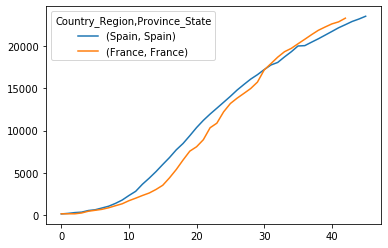

In [24]:
df_qry.plot()

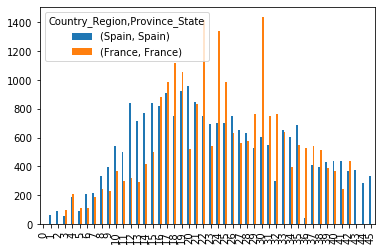

In [25]:
df_qry.diff().plot(kind='bar')